In [1]:
import itertools
import numpy as np
import pandas as pd

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


from arch import arch_model

from sklearn import model_selection

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_palette("dark")

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import yfinance as yf
from prophet import Prophet
import datetime

In [2]:
rub=yf.download('USDRUB=X', '2020-01-01')
rub=rub.drop('Volume',axis=1)
rub['Date']=rub.index
rub             

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close       Date
Date                                                                        
2020-01-01  62.028301  62.028301  62.028301  62.028301  62.028301 2020-01-01
2020-01-02  61.830002  62.147999  61.563000  61.830002  61.830002 2020-01-02
2020-01-03  61.694199  62.224998  61.694199  61.694199  61.694199 2020-01-03
2020-01-06  62.013802  62.323002  61.717499  62.029999  62.029999 2020-01-06
2020-01-07  61.775101  62.086201  61.591702  61.775002  61.775002 2020-01-07
...               ...        ...        ...        ...        ...        ...
2023-09-18  96.764999  97.127502  95.540001  96.764999  96.764999 2023-09-18
2023-09-19  95.915001  96.717499  94.894997  95.915001  95.915001 2023-09-19
2023-09-20  95.964996  97.102501  95.889999  97.466003  97.466003 2023-09-20
2023-09-21  95.989998  96.615997  95.349998  95.989998  95.989998 2023-09-21
2023-09-23  95.080002  96.443199  94.599998  95.279999  95.279999 2023-09-23

[973 rows x 6 columns]

In [3]:
rub['Close'].isna().sum()

0

In [4]:
rub[rub['Close']==0].count()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Date         0
dtype: int64

In [5]:
def plot_line(data: pd.DataFrame, size_inches: tuple):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*size_inches)
    sns.lineplot(data=data, ax=ax)
    plt.show()

def plot_moving_average(data: pd.DataFrame,
                        column_name: str,
                        column_title: str, column_label: str,
                        smoothed_title: str, smoothed_label: str,
                        start_window: int, windows_delta: int, number_of_windows: int,
                        size_inches: tuple):
    fig, ax = plt.subplots(number_of_windows, 2)
    # fig.tight_layout(pad=2.0)
    plt.subplots_adjust(top=1.6, wspace=0.1)
    fig.set_size_inches(*size_inches)

    figure_index = 0
    for window in np.arange(start_window, start_window + number_of_windows * windows_delta, windows_delta):
        ax[figure_index, 0].plot(data[column_name], color="blue", label=column_label)
        ax[figure_index, 0].set_title(column_title, size=10)
        ax[figure_index, 0].legend()

        ax[figure_index, 1].plot(data[column_name].rolling(window=window).mean(),
                                color="orange", label=smoothed_label)
        ax[figure_index, 1].plot(data[column_name].rolling(window=window).std(),
                                color="red", label='Rolling Std. Dev.')
        ax[figure_index, 1].set_title(
            f"Moving Average (window size: {window}) - {smoothed_title}", size=10)
        ax[figure_index, 1].legend()

        figure_index = figure_index + 1

    plt.show()

def plot_seasonal_decompose(data, model: str, size_inches: tuple):
    result = seasonal_decompose(data, model=model)
    fig = result.plot()
    fig.set_size_inches(*size_inches)
    fig.tight_layout(h_pad=0.0, w_pad=0.0)
    plt.show()
    return result

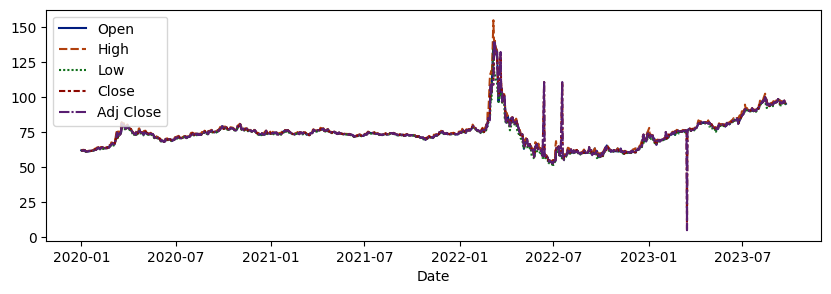

In [6]:
plot_line(data=rub, size_inches=(10, 3))

Разделим временной ряд на тренировочную и тестовую выборки (последние 3 месяца).

In [7]:
start_time=rub['Date'][-1] 
rub=rub.drop('Date',axis=1)
start_time=start_time- datetime.timedelta(weeks=12)
start_time

Timestamp('2023-07-01 00:00:00')

In [8]:
train_data = rub.loc[:start_time]
test_data = rub.loc[start_time:]
train_data.shape, test_data.shape

((913, 5), (60, 5))

In [9]:
train_data

Open       High        Low      Close  Adj Close
Date                                                             
2020-01-01  62.028301  62.028301  62.028301  62.028301  62.028301
2020-01-02  61.830002  62.147999  61.563000  61.830002  61.830002
2020-01-03  61.694199  62.224998  61.694199  61.694199  61.694199
2020-01-06  62.013802  62.323002  61.717499  62.029999  62.029999
2020-01-07  61.775101  62.086201  61.591702  61.775002  61.775002
...               ...        ...        ...        ...        ...
2023-06-26  83.614998  86.974998  83.614998  83.614998  83.614998
2023-06-27  84.375000  85.555000  84.375000  84.375000  84.375000
2023-06-28  85.339996  86.839996  84.764000  85.339996  85.339996
2023-06-29  85.855003  87.714996  85.855003  85.855003  85.855003
2023-06-30  86.824997  89.764999  86.824997  86.824997  86.824997

[913 rows x 5 columns]

### Скользящие средние

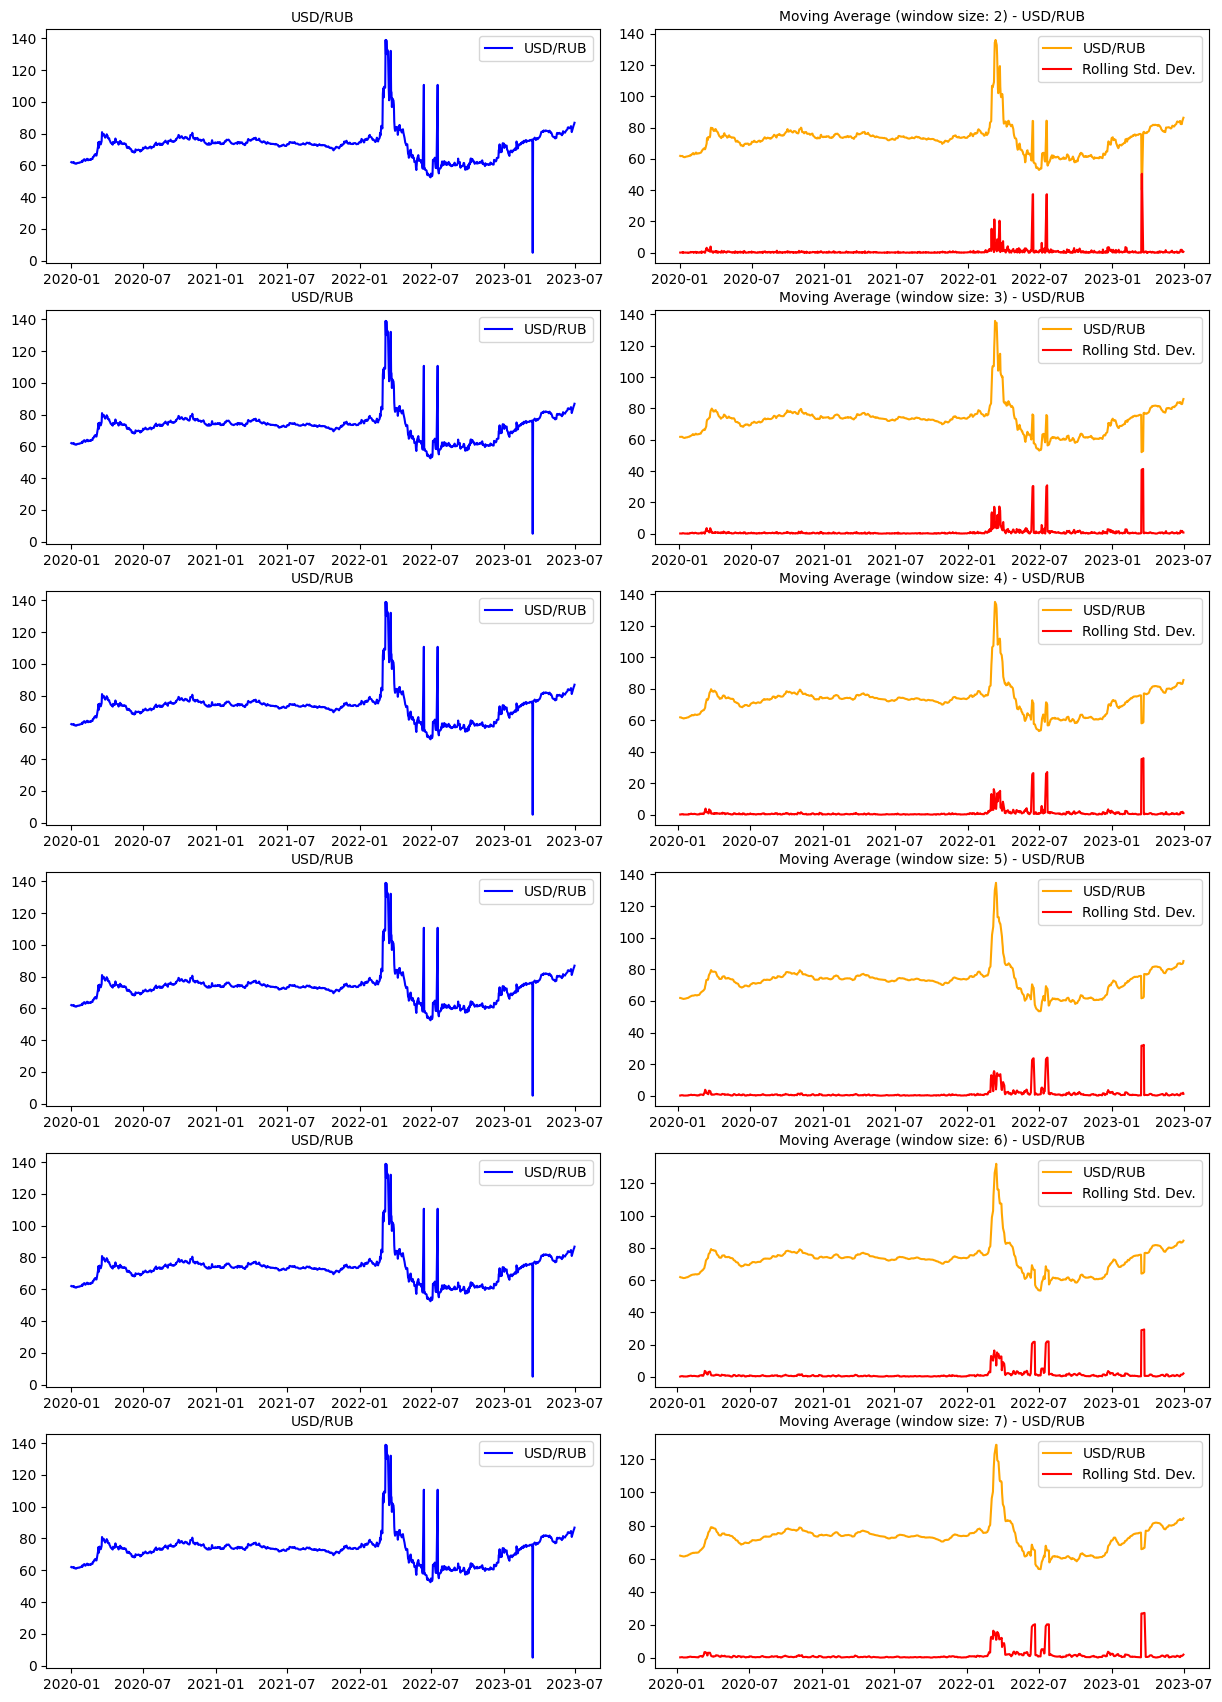

In [10]:
plot_moving_average(data=train_data,
                    column_name='Close',
                    column_title='USD/RUB', column_label='USD/RUB',
                    smoothed_title='USD/RUB', smoothed_label='USD/RUB',
                    start_window=2, windows_delta=1, number_of_windows=6,
                    size_inches=(15, 11))

## Декомпозиция на тренд и сезонность

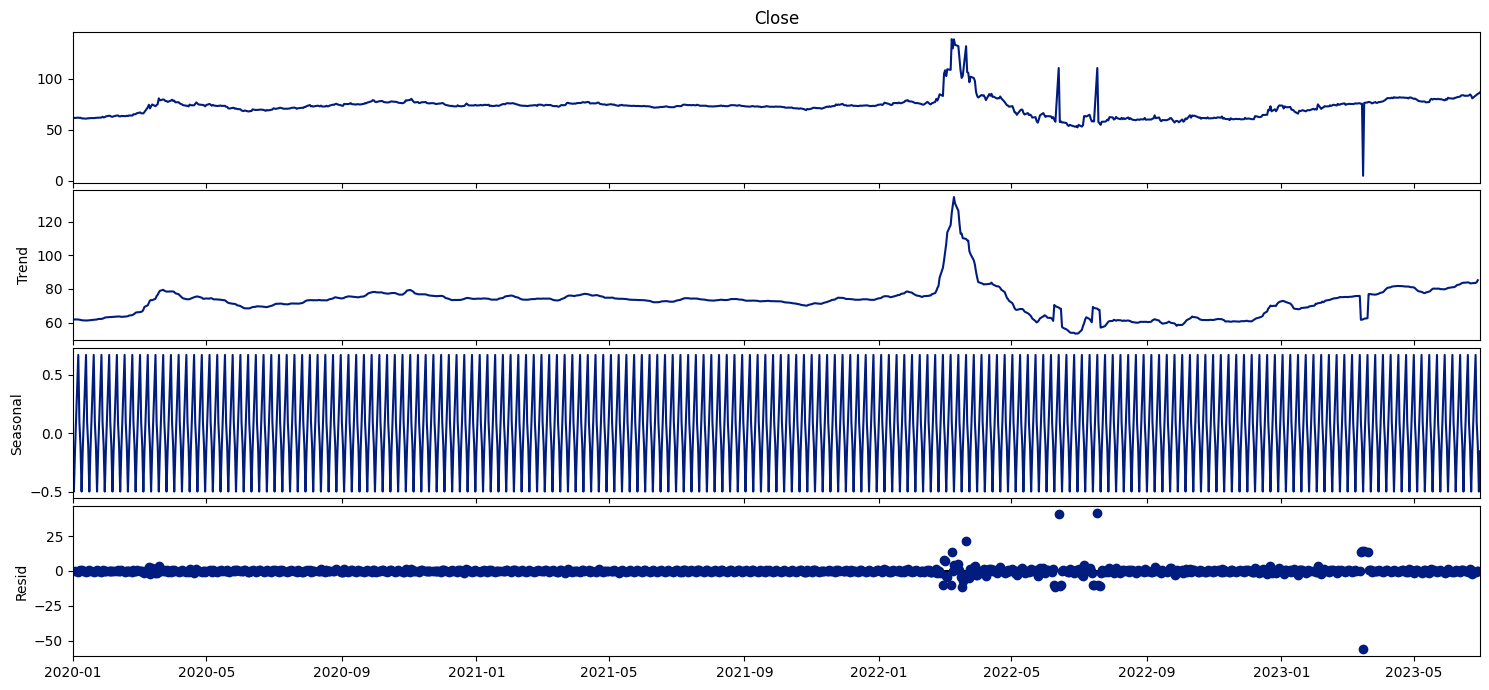

In [11]:
seasonal_decompose_result = plot_seasonal_decompose(
    data=train_data['Close'].interpolate(method='linear'),
    model='additive',
    size_inches=(15, 7)
)

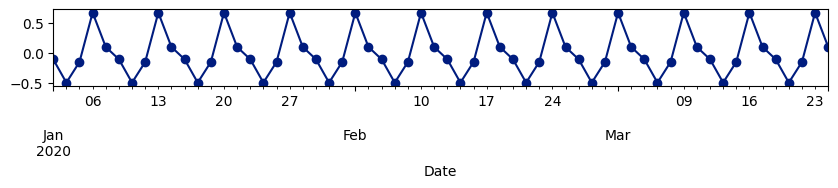

In [12]:
plt.rcParams["figure.figsize"] = 10, 1
seasonal_decompose_result.seasonal[:60].plot(marker="o")
plt.show()

Сезонность присутствует.

## Стационарность ряда GDP

In [13]:
def plot_acf(data, lags: int, size_inches: tuple):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*size_inches)
    sgt.plot_acf(data, zero=True, lags=lags, ax=ax)
    plt.show()


def plot_pacf(data, lags: int, size_inches: tuple):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*size_inches)
    sgt.plot_pacf(data, zero=True, lags=lags, method='ywm', ax=ax)
    plt.show()


def plot_acf_pacf(data, acf_lags: int, pacf_lags: int, size_inches: tuple):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(*size_inches)
    sgt.plot_acf(data, lags=acf_lags, ax=axes[0])
    sgt.plot_pacf(data, lags=pacf_lags, method='ywm', ax=axes[1])
    plt.show()


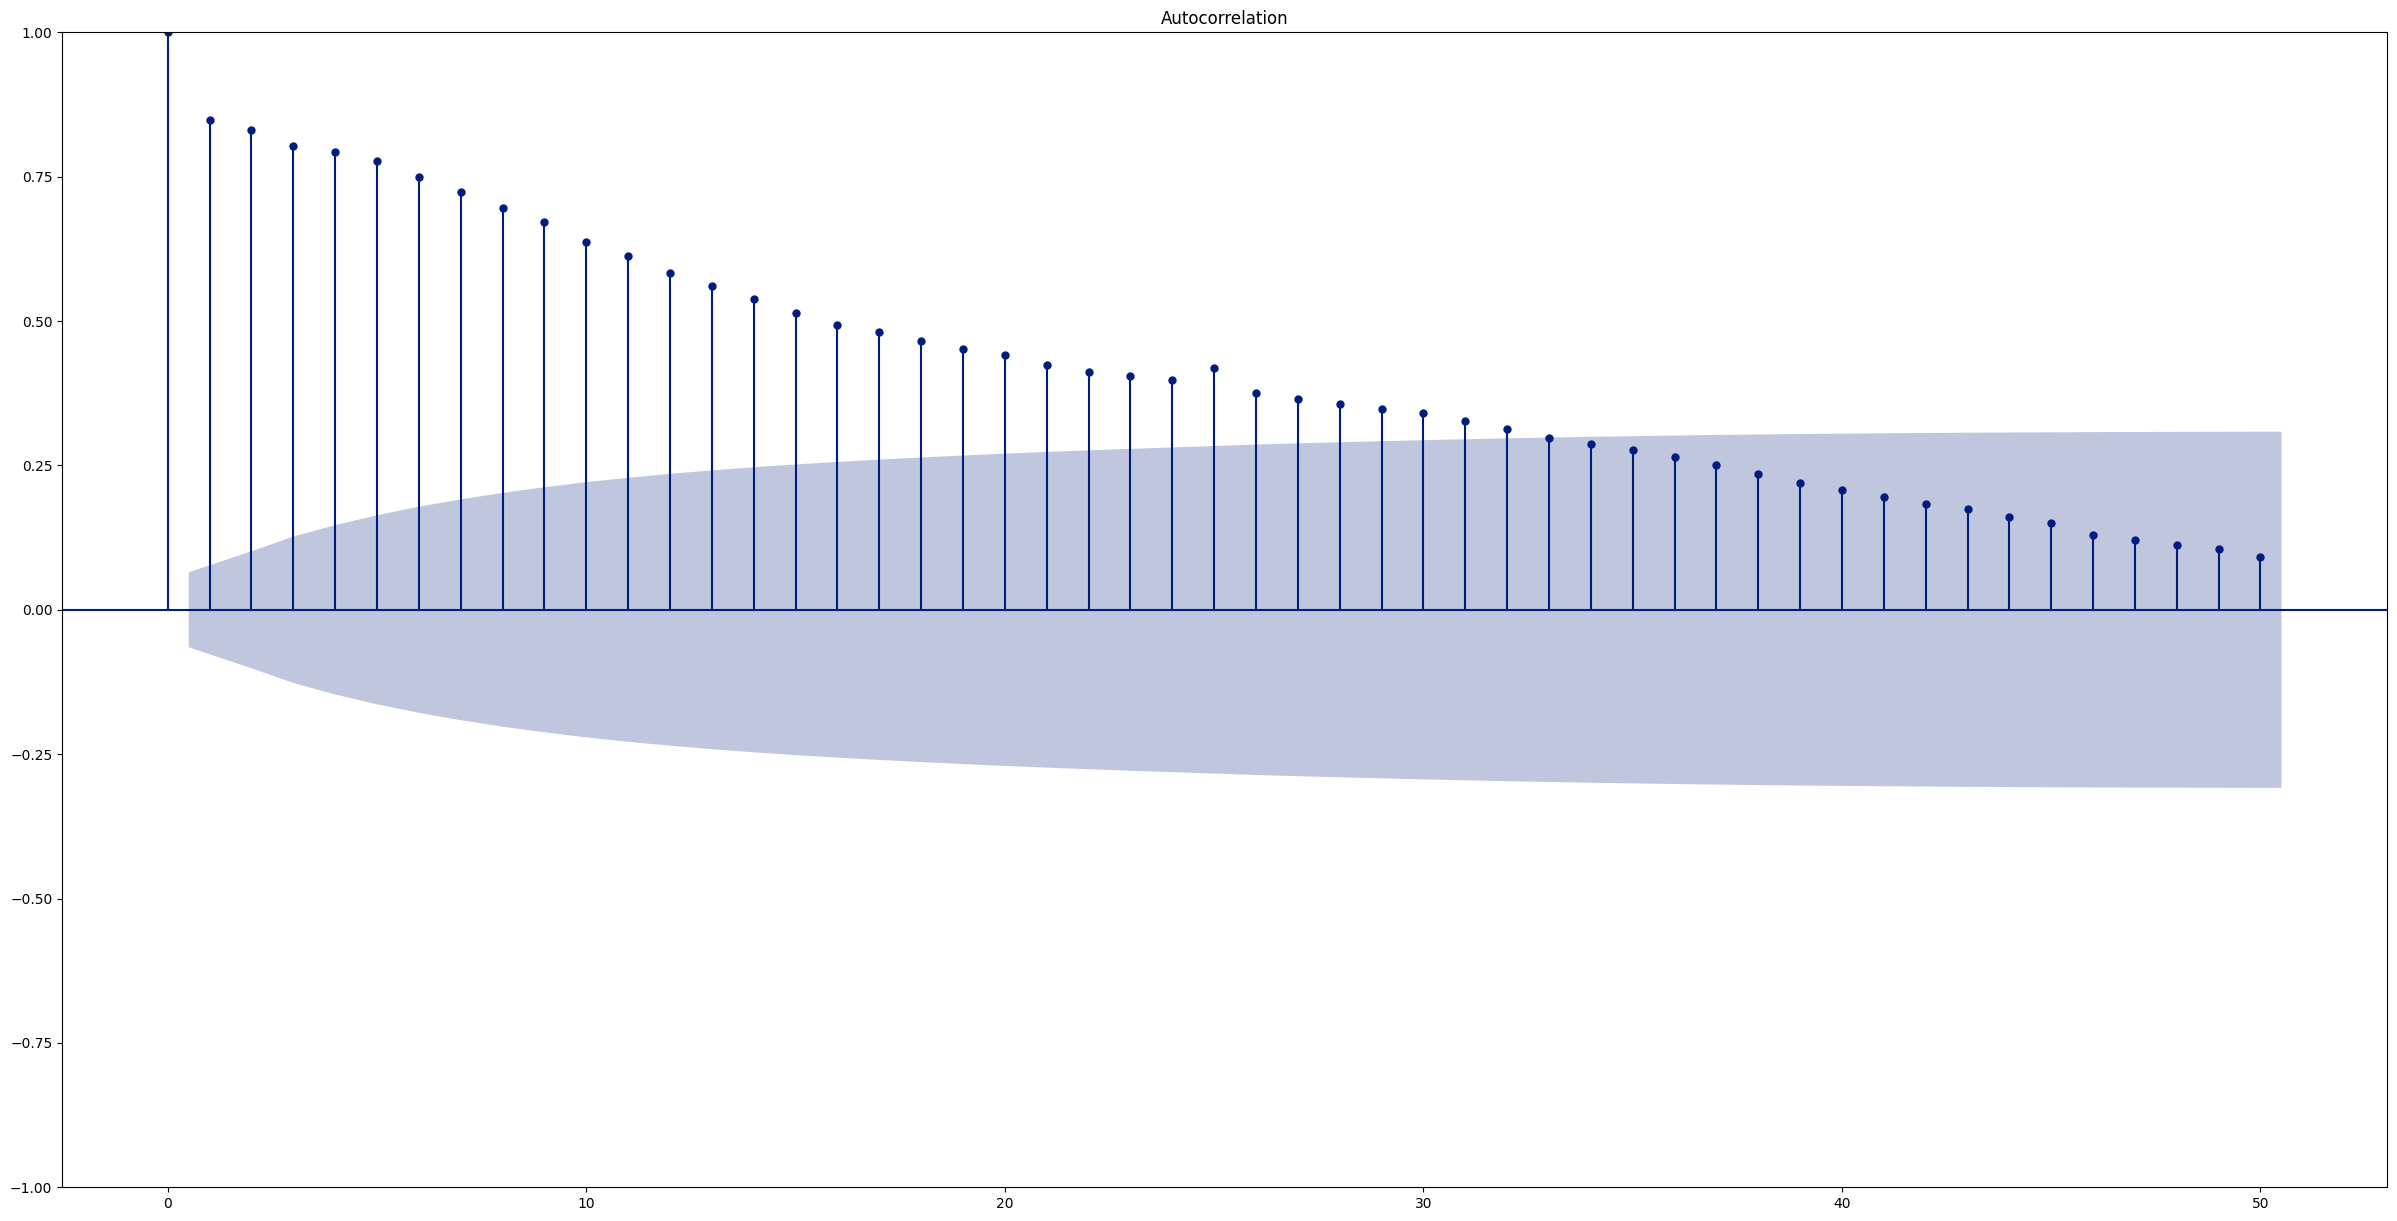

In [14]:
plot_acf(data=train_data['Close'], lags=50, size_inches=(30, 15))

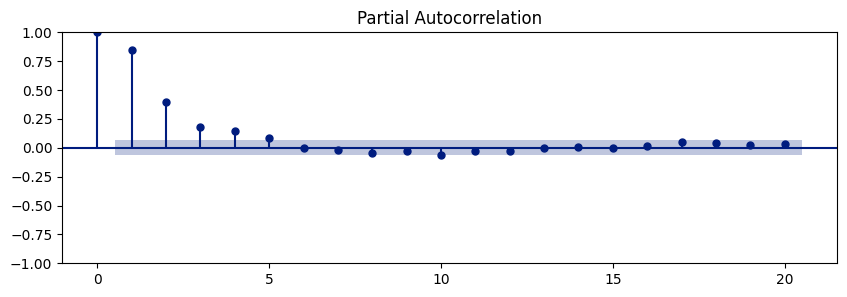

In [15]:
plot_pacf(data=train_data['Close'], lags=20, size_inches=(10, 3))

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913 entries, 2020-01-01 to 2023-06-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       913 non-null    float64
 1   High       913 non-null    float64
 2   Low        913 non-null    float64
 3   Close      913 non-null    float64
 4   Adj Close  913 non-null    float64
dtypes: float64(5)
memory usage: 42.8 KB


#### Тест Дики-Фуллера

In [17]:
def test_dickey_fuller(data, maxlag: int = 10, regression: str = 'c'):
    result = adfuller(data, maxlag=maxlag)
    print(f'adf: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('used lag: ', result[2])
    print('Critical values: ', result[4])
    print('----------')
    if result[0] > result[4]['5%']:
        print(f"Ряд нестационарен: статистика теста {result[0]:.3f} больше критического значения {result[4]['5%']:.3f} для уровня значимости 5%.")
    else:
        print('Ряд стационарен')

In [18]:
test_dickey_fuller(train_data['Close'], maxlag=20)

adf: -3.332
p-value: 0.014
used lag:  4
Critical values:  {'1%': -3.4375723382479735, '5%': -2.8647283387229963, '10%': -2.568467680189796}
----------
Ряд стационарен


### Подберем параметры q,p и d

In [19]:

smodel = pm.auto_arima(
    train_data['Close'],
    start_p=1,
    d=2,
    start_q=1,
    max_p=7,
    max_q=7,
    D=1,
    start_P=0,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6613.400, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6083.514, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=6611.400, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5880.989, Time=0.13 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=5755.541, Time=0.15 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=5647.718, Time=0.16 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5582.525, Time=0.21 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=5537.261, Time=0.27 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=5511.826, Time=0.30 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(7,2,0)(0,0,0)[0]             : AIC=5509.828, Time=0.16 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=5535.262, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  913
Model:               SARIMAX(7, 2, 0)   Log Likelihood               -2746.914
Date:                Sat, 23 Sep 2023   AIC                           5509.828
Time:                        21:08:53   BIC                           5548.344
Sample:                    01-01-2020   HQIC                          5524.532
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4366      0.006   -225.259      0.000      -1.449      -1.424
ar.L2         -1.5122      0.015   -102.922      0.000      -1.541      -1.483
ar.L3         -1.4203      0.023    -61.554      0.000      -1.465      -1.375
ar.L4         -1.1698      0.030    -38.545      0.000      -1.229      -1.110
ar.L5         -0.8103      0.034    -24.062      0.000      -0.876      -0.744
ar.L6         -0.4647      0.028    -16.747      0.000      -0.519      -0.410
ar.L7         -0.1717      0.016    -10.983      0.000      -0.202      -0.141
sigma2        24.2779      0.180    134.803      0.000      23.925      24.631
===================================================================================
Ljung-Box (L1) (Q):                   0.97   Jarque-Bera (JB):            277317.27
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):              57.29   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
p=7
d=2
q=0

## ARIMA

In [21]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_data["Close"].dropna(), order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  913
Model:                 ARIMA(7, 2, 0)   Log Likelihood               -2746.914
Date:                Sat, 23 Sep 2023   AIC                           5509.828
Time:                        21:08:53   BIC                           5548.344
Sample:                    01-01-2020   HQIC                          5524.532
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4366      0.006   -225.259      0.000      -1.449      -1.424
ar.L2         -1.5122      0.015   -102.922      0.000      -1.541      -1.483
ar.L3         -1.4203      0.023    -61.554      0.000      -1.465      -1.375
ar.L4         -1.1698      0.030    -38.545      0.000      -1.229      -1.110
ar.L5         -0.8103      0.034    -24.062      0.000      -0.876      -0.744
ar.L6         -0.4647      0.028    -16.747      0.000      -0.519      -0.410
ar.L7         -0.1717      0.016    -10.983      0.000      -0.202      -0.141
sigma2        24.2779      0.180    134.803      0.000      23.925      24.631
===================================================================================
Ljung-Box (L1) (Q):                   0.97   Jarque-Bera (JB):            277317.27
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):              57.29   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
pred_df = pd.DataFrame(index=rub.index)

pred_df["model_preds"] = arima_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

pred_df["Close"] = rub["Close"]

forecast = arima_model_fit.get_forecast(len(test_data.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_data.index, "model_preds_lower"] = forecast_df["lower Close"]
pred_df.at[test_data.index, "model_preds_upper"] = forecast_df["upper Close"]

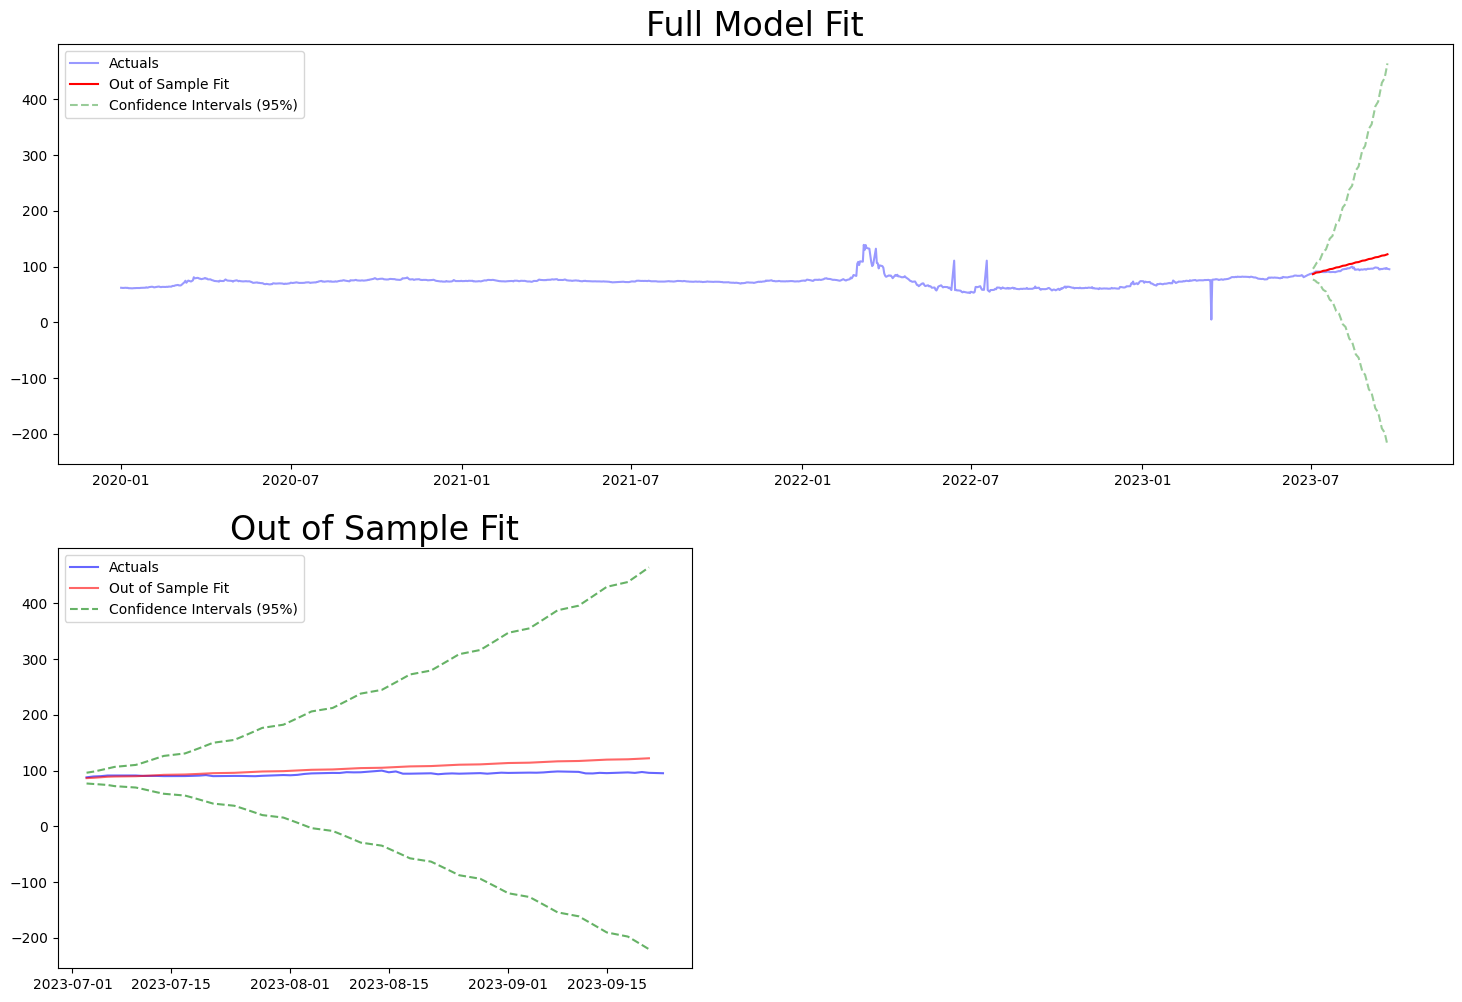

In [23]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["Close"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_data.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_data.index]["Close"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

По результатам прогноза видно, что доверительный интервал слишком большой, и прогнозируется рост курса, но на самом деле рост не такой значительный.

## Prophet

21:08:53 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing


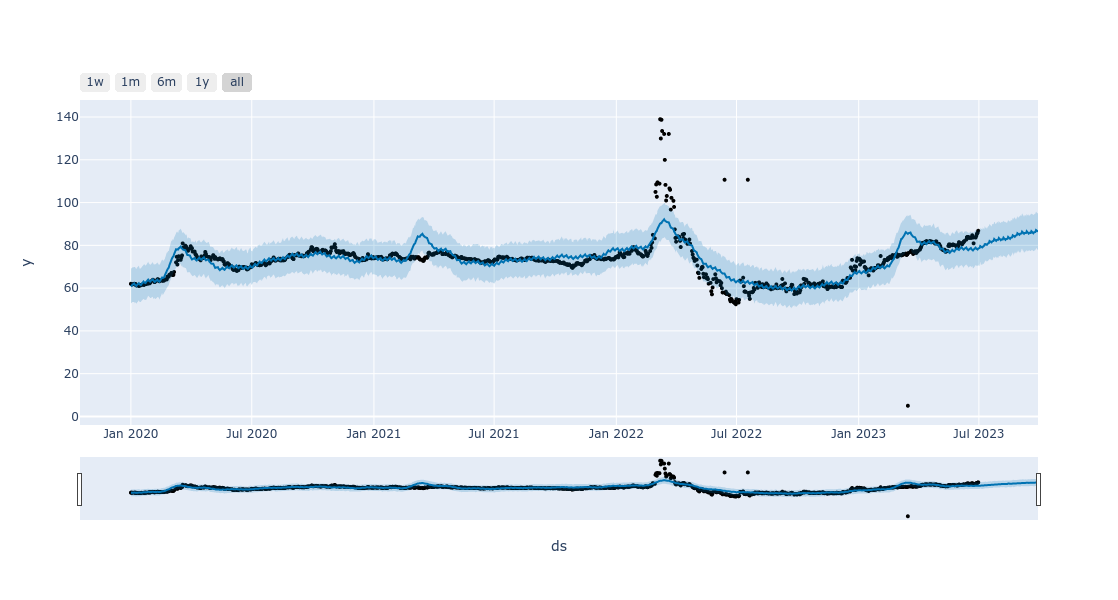

In [24]:
df=train_data
df['Date']=df.index
dff=pd.DataFrame()

dff['ds']=df['Date']
dff['y']=df['Close']
dff=dff.reset_index()
dff.drop(['Date'],axis=1)

m=Prophet()
m.fit(dff)
future=m.make_future_dataframe(periods=90)
forecast=m.predict(future)
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
fig=plot_plotly(m,forecast)
py.iplot(fig)

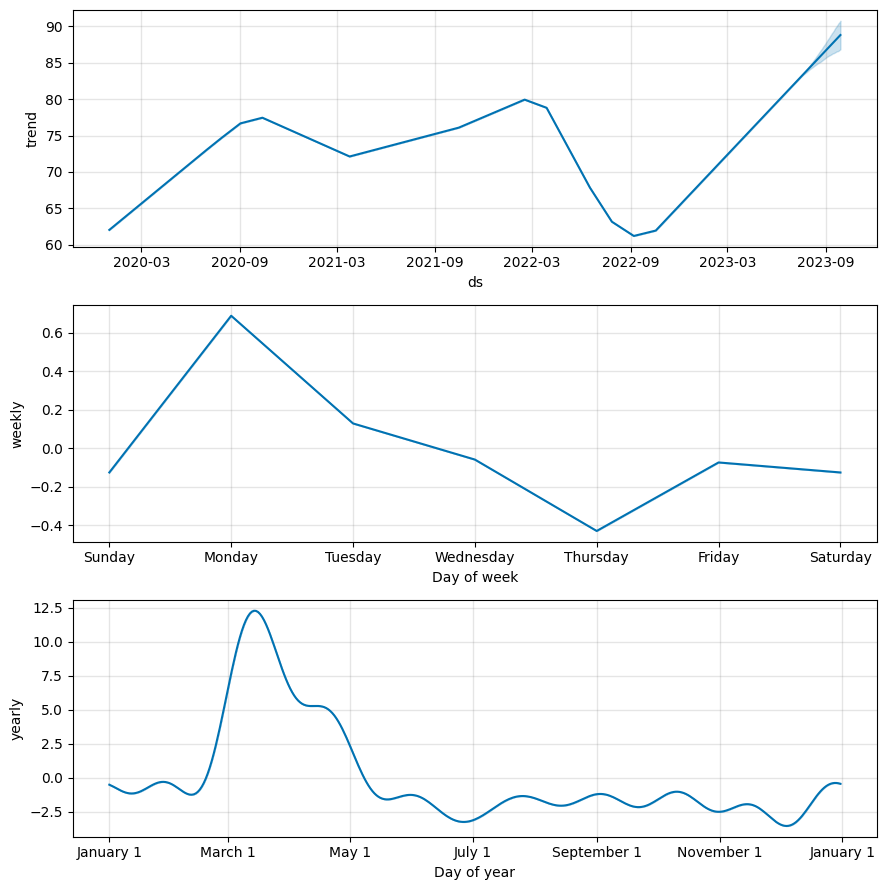

In [25]:
fig2 = m.plot_components(forecast)

По результатам исследований видно, что Prophet показал лучшие результаты, т.к. доверительный интервал у него не подвержен такому большому разбросу, предсказание тренда соответсвует действительности, поэтому для дальнейшей работы буду использовать Prophet.

## Оценка модели Prophet

In [26]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='90 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

  0%|          | 0/19 [00:00<?, ?it/s]

21:08:54 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing
21:08:54 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1]

horizon         mse       rmse       mae      mape     mdape     smape  \
0  9 days   56.733896   7.532191  5.121591  0.071870  0.043993  0.070994   
1 10 days   66.964329   8.183174  5.539554  0.076987  0.045930  0.076520   
2 11 days   71.850641   8.476476  5.764991  0.079679  0.049663  0.079850   
3 12 days   81.904557   9.050114  6.183340  0.083653  0.056716  0.084152   
4 13 days  102.385865  10.118590  6.672684  0.087873  0.056716  0.089219   

   coverage  
0  0.502927  
1  0.483607  
2  0.475410  
3  0.454333  
4  0.434426

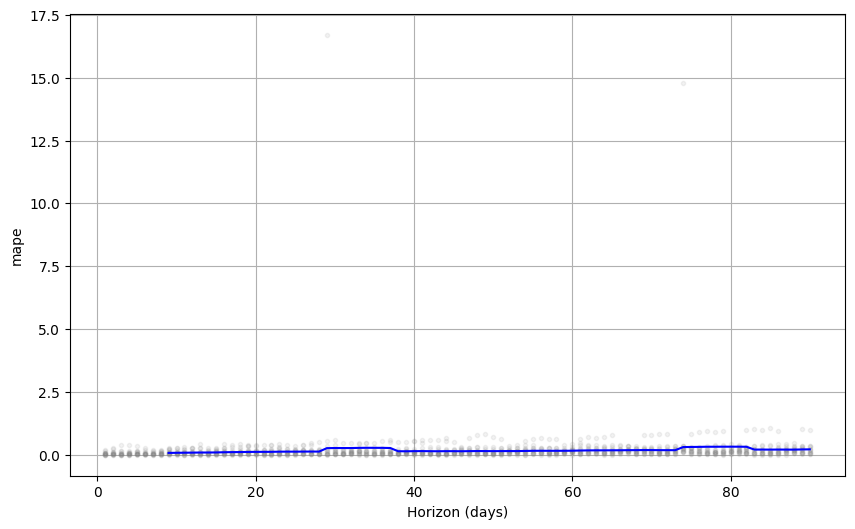

In [27]:
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape')

MAPE (mean absolute percent error) находится около 0, подъемы около 40 и 80 могут быть вызваны геополитическими новостями.